<a href="https://colab.research.google.com/github/datagy/CRISP-DM/blob/master/CRISP_DM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring the Boston AirBNB Open Data Set
## Introduction
### AirBNB Boston Data Analysis
In this notebook, we'll explore the Boston AirBNB Open Data Set to explore correlations with prices, the correlation of ratings on availability, and how AirBnB has grown in Boston. 

### Business Understanding
In addition, we will want to explore the following other questions:
* How many units are sitting vacant throughout the year, potentially causing detrimental effects to the housing market in Boston?
* How has the short-term rental economy grown, in terms of number of hosts?
* How affordable is airbnb compared to a regular rental unit in various neighborhoods?
* How many units exist away from the city center?
* How affordable are units further away from the city center?

The datasets have been obtained via [Kaggle](https://www.kaggle.com/airbnb/boston) and contain three different files:
* calendar: the availability of homes
* listings: information on different listings
* reviews: reviews of Airbnb listings

Let's begin by importing the required libraries:

In [2]:
!pip install geopandas

     |████████████████████████████████| 972kB 2.7MB/s 
     |████████████████████████████████| 10.9MB 13.8MB/s 
     |████████████████████████████████| 14.8MB 301kB/s 


In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import geopandas as gps
%matplotlib inline
pd.set_option('display.max_columns', 100)

Let's now import our datasets into dataframes and explore each of them a little bit.

In [4]:
calendar = pd.read_csv('https://datagy.io/wp-content/uploads/2020/09/calendar.csv', parse_dates=['date'])
listings = pd.read_csv('https://datagy.io/wp-content/uploads/2020/09/listings.csv')
reviews = pd.read_csv('https://datagy.io/wp-content/uploads/2020/09/reviews.csv')

## Data Understanding & Prepare Data

### Calendar Data Set - Exploration and Cleaning
Let's begin by exploring and cleaning the `calendar` dataset:

In [5]:
calendar.head()

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


In [6]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   listing_id  1308890 non-null  int64         
 1   date        1308890 non-null  datetime64[ns]
 2   available   1308890 non-null  object        
 3   price       643037 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 39.9+ MB


From the `.head()` method, we can see that the `available` column is likely meant to be a boolean. Let's print out the unique values in this column to see if this is true.

In [7]:
calendar['available'].unique()

array(['f', 't'], dtype=object)

Let's convert this to a boolean variable:

In [8]:
calendar['available'] = calendar['available'].map({'f': False, 't': True})

Now let's explore the missing values in this dataframe a little bit:

In [9]:
calendar.isnull().sum()

listing_id         0
date               0
available          0
price         665853
dtype: int64

The only column that has missing values is the `price` column. Let's see if we can determine where these values are missing (i.e., if there exists any pattern). 

In [10]:
calendar[calendar['price'].isnull()]['available'].unique()

array([False])

What this tells us is that whenever the price value is missing, the unit is not available. Let's see if there is ever a price for the unit if the unit is also not available.

In [11]:
calendar[~calendar['price'].isnull()]['available'].unique()

array([ True])

This tells us that whenever there is a price available, the unit is also available.

We can also see that the price column is listed as an `object (string)` data type. Let's see what's happening there and clean the data to make it easier to work with:

In [12]:
calendar[~calendar['price'].isnull()]

,listing_id,date,available,price
365,3075044,2017-08-22,True,$65.00
366,3075044,2017-08-21,True,$65.00
367,3075044,2017-08-20,True,$65.00
368,3075044,2017-08-19,True,$75.00
369,3075044,2017-08-18,True,$75.00
...,...,...,...,...
1308875,14504422,2016-09-20,True,$62.00
1308876,14504422,2016-09-19,True,$62.00
1308877,14504422,2016-09-18,True,$62.00
1308878,14504422,2016-09-17,True,$62.00


It appears that the dollar sign and the comma are conflicting with these values being read as a `float` data type. Let's remove these and convert the column to a `float`:

In [13]:
calendar['price'] = calendar['price'].str.replace("$", "").str.replace(",","").astype('float')

Finally, let's take a look at the data itself to see how reasonable the values are, i.e., to spot any outliers:

In [14]:
calendar.describe()

,listing_id,price
count,1.308890e+06,643037.000000
mean,8.442118e+06,198.438909
std,4.500149e+06,180.142913
min,3.353000e+03,11.000000
25%,4.679319e+06,85.000000
50%,8.578710e+06,150.000000
75%,1.279603e+07,255.000000
max,1.493346e+07,7163.000000


We can see that there are some odd outliers, such as the minimum value of $11 and the max value of over $7,000! Let's create a box plot to explore the price variable a bit more:

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


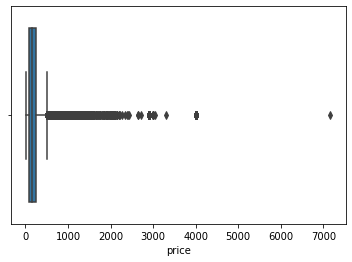

In [15]:
sns.boxplot(calendar['price'])

There are a fair number of outliers on the higher end. Let's leave them for now but keep this in mind for later, in case these skew our other analyses.

### Listings Data Set - Exploration and Cleaning
Let's begin by exploring and cleaning the `listings` dataset:

In [16]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",NaN,"The bus stop is 2 blocks away, and frequent. B...","You will have access to 2 bedrooms, a living r...",NaN,Clean up and treat the home the way you'd like...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,31303940,https://www.airbnb.com/users/show/31303940,Virginia,2015-04-15,"Boston, Massachusetts, United States",We are country and city connecting in our deck...,NaN,NaN,NaN,f,https://a2.muscache.com/im/pictures/5936fef0-b...,https://a2.muscache.com/im/pictures/5936fef0-b...,Roslindale,1,1,"['email', 'phone', 'facebook', 'reviews']",t,f,"Birch Street, Boston, MA 02131, United States",Roslindale,Roslindale,NaN,Boston,MA,02131,Boston,"Boston, MA",US,United States,42.282619,-71.133068,t,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",NaN,$250.00,NaN,NaN,NaN,$35.00,1,$0.00,2,1125,2 weeks ago,NaN,0,0,0,0,2016-09-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,"If I am at home, I am likely working in my hom...",Pet friendly but please confirm with me if the...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,2572247,https://www.airbnb.com/users/show/2572247,Andrea,2012-06-07,"Boston, Massachusetts, United States",I live in Boston and I like to travel and have...,within an hour,100%,100%,f,https://a2.muscache.com/im/users/2572247/profi...,https://a2.muscache.com/im/users/2572247/profi...,Roslindale,1,1,"['email', 'phone', 'facebook', 'linkedin', 'am...",t,t,"Pinehurst Street, Boston, MA 02131, United Sta

Let's reduce the columns available here to make them a bit easier to manage and analyze. We won't be taking on any NLP with this analysis, so we'll drop any columns that are made up of long strings of text. We'll also drop some columns that likely won't impact our ability to report on our earlier questions.

In [17]:
cols = ['id', 'host_id', 'host_since', 'host_total_listings_count', 
        'neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates', 'bathrooms', 
        'bedrooms', 'beds', 'square_feet', 'price', 'weekly_price', 'number_of_reviews', 'review_scores_rating',
        'monthly_price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 
        'minimum_nights', 'instant_bookable', 'cancellation_policy']

listings = listings[cols]
listings.head()

,id,host_id,host_since,host_total_listings_count,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,square_feet,price,weekly_price,number_of_reviews,review_scores_rating,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,instant_bookable,cancellation_policy
0,12147973,31303940,2015-04-15,1,Roslindale,House,Entire home/apt,4,1.5,2.0,3.0,NaN,$250.00,NaN,0,NaN,NaN,NaN,$35.00,1,$0.00,2,f,moderate
1,3075044,2572247,2012-06-07,1,Roslindale,Apartment,Private room,2,1.0,1.0,1.0,NaN,$65.00,$400.00,36,94.0,NaN,$95.00,$10.00,0,$0.00,2,t,moderate
2,6976,16701,2009-05-11,1,Roslindale,Apartment,Private room,2,1.0,1.0,1.0,NaN,$65.00,$395.00,41,98.0,"$1,350.00",NaN,NaN,1,$20.00,3,f,moderate
3,1436513,6031442,2013-04-21,1,Roslindale,House,Private room,4,1.0,1.0,2.0,NaN,$75.00,NaN,1,100.0,NaN,$100.00,$50.00,2,$25.00,1,f,moderate
4,7651065,15396970,2014-05-11,1,Roslindale,House,Private room,2,1.5,1.0,2.0,NaN,$79.00,NaN,29,99.0,NaN,NaN,$15.00,1,$0.00,2,f,flexible


In [18]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         3585 non-null   int64  
 1   host_id                    3585 non-null   int64  
 2   host_since                 3585 non-null   object 
 3   host_total_listings_count  3585 non-null   int64  
 4   neighbourhood_cleansed     3585 non-null   object 
 5   property_type              3582 non-null   object 
 6   room_type                  3585 non-null   object 
 7   accommodates               3585 non-null   int64  
 8   bathrooms                  3571 non-null   float64
 9   bedrooms                   3575 non-null   float64
 10  beds                       3576 non-null   float64
 11  square_feet                56 non-null     float64
 12  price                      3585 non-null   object 
 13  weekly_price               892 non-null    objec

We can see that we need to clean all the price related columns to be floats, similar to what we'd done with the calendar data. Similarly, we'll want to convert `instant_bookable` to a float, and convert `host_since` to a datetime data type.

In [19]:
def clean_listings():
  """Takes in the listings dataframe and returns cleaned columns."""
  # Clean all price columns
  price_cols = ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people']
  for col in price_cols:
      listings[col] = listings[col].str.replace("$", "").str.replace(",","").astype('float')  

  # Clean boolean columns
  listings['instant_bookable'] = listings['instant_bookable'].map({'f':False, 't':True}).astype('bool')

  # Clean host_since column by converting to datetime
  listings['host_since'] = pd.to_datetime(listings['host_since'])

  return listings

listings = clean_listings()

In [20]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         3585 non-null   int64         
 1   host_id                    3585 non-null   int64         
 2   host_since                 3585 non-null   datetime64[ns]
 3   host_total_listings_count  3585 non-null   int64         
 4   neighbourhood_cleansed     3585 non-null   object        
 5   property_type              3582 non-null   object        
 6   room_type                  3585 non-null   object        
 7   accommodates               3585 non-null   int64         
 8   bathrooms                  3571 non-null   float64       
 9   bedrooms                   3575 non-null   float64       
 10  beds                       3576 non-null   float64       
 11  square_feet                56 non-null     float64       
 12  price 

We can see that we have a large variety of columns with missing values. Let's calculate proportions of missing values:

In [21]:
(listings.isnull().sum() / listings.shape[0]).sort_values(ascending=False)

square_feet                  0.984379
monthly_price                0.752301
weekly_price                 0.751185
security_deposit             0.625662
cleaning_fee                 0.308787
review_scores_rating         0.226778
bathrooms                    0.003905
bedrooms                     0.002789
beds                         0.002510
property_type                0.000837
accommodates                 0.000000
host_id                      0.000000
host_since                   0.000000
host_total_listings_count    0.000000
neighbourhood_cleansed       0.000000
room_type                    0.000000
cancellation_policy          0.000000
instant_bookable             0.000000
price                        0.000000
number_of_reviews            0.000000
guests_included              0.000000
extra_people                 0.000000
minimum_nights               0.000000
id                           0.000000
dtype: float64

The square_feet column is *mostly* empty, so let's drop that one altogether. For the `monthly_price` and `weekly_price` column, our main interest is whether long-term stay discounts are available. Let's combine these into a single boolean `discount` column. 

For the remaining price columns, a missing value likely indicates that there is no fee (e.g., `cleaning_fee`, `security_deposit`). Let's fill these with 0. This applies to `bathrooms`, `bedrooms`, and `beds` too.

Finally, `property_type` is missing for a number of rows. Let's drop these rows, as we'll be sussing out property type specifically.

We'll leave the `reviews_score_rating` column with nulls, as replacing them with zeroes would not be practical in this purpose.

In [22]:
# Create a discount column if there is a monthly_price or a weekly_price listed:
listings['discount'] = listings['monthly_price'].isnull() | listings['weekly_price'].isnull()
listings.drop(columns=['monthly_price', 'weekly_price'], inplace=True)

# Drop missing records for property_type
listings.dropna(subset=['property_type'], inplace=True)

# Fill zero for missing values
for col in ['cleaning_fee', 'security_deposit', 'bathrooms', 'bedrooms', 'beds']:
    listings[col].fillna(0, inplace=True)
    
# Drop square_feet columns
listings = listings.drop('square_feet', axis=1)

In [23]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3582 entries, 0 to 3584
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         3582 non-null   int64         
 1   host_id                    3582 non-null   int64         
 2   host_since                 3582 non-null   datetime64[ns]
 3   host_total_listings_count  3582 non-null   int64         
 4   neighbourhood_cleansed     3582 non-null   object        
 5   property_type              3582 non-null   object        
 6   room_type                  3582 non-null   object        
 7   accommodates               3582 non-null   int64         
 8   bathrooms                  3582 non-null   float64       
 9   bedrooms                   3582 non-null   float64       
 10  beds                       3582 non-null   float64       
 11  price                      3582 non-null   float64       
 12  number

### Reviews Data Set - Exploration and Cleaning
Let's begin by exploring and cleaning the `reviews` dataset:

In [24]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...


## Data Analysis and Visualization
Let's begin taking a look at the `listings` dataset. In particular, let's explore the types of housing available. 

Airbnb is assumed to have an impact on the availability of vacancy for its market's residents. Let's see the breakdown of property types. We'll also want to look at how the spread of number of units per owner.





### Exploring Housing Types

Let's start by looking at housing types:

#### Data Modeling

In [25]:
listings['property_type'].value_counts(normalize=True)

Apartment          0.729202
House              0.156896
Condominium        0.064489
Townhouse          0.015075
Bed & Breakfast    0.011446
Loft               0.010888
Other              0.004746
Boat               0.003350
Villa              0.001675
Entire Floor       0.001117
Dorm               0.000558
Camper/RV          0.000279
Guesthouse         0.000279
Name: property_type, dtype: float64

We can see that apartments, houses, and condos make up the majority of units (roughly 95%). 

Let's see how many different room types there are available:

In [26]:
listings['room_type'].value_counts()

Entire home/apt    2125
Private room       1377
Shared room          80
Name: room_type, dtype: int64

In [27]:
listings['room_type'].value_counts(normalize=True)

Entire home/apt    0.593244
Private room       0.384422
Shared room        0.022334
Name: room_type, dtype: float64

Let's also take a look at how many units each owner has. We can filter down to the `host_id` and `host_total_listings_count` columns, remove duplicates, and look into this:

In [28]:
units_per_host = listings[['host_id', 'host_total_listings_count']]
units_per_host = units_per_host.drop_duplicates()
units_per_host['host_total_listings_count'].value_counts()

1      1615
2       297
3        94
4        48
5        29
6        18
7        17
8         8
11        6
12        4
13        4
18        3
16        3
14        3
22        3
9         3
24        2
15        2
17        2
10        2
20        2
0         2
749       1
28        1
30        1
52        1
122       1
363       1
21        1
37        1
45        1
71        1
307       1
313       1
558       1
Name: host_total_listings_count, dtype: int64

Some of these values seem incorrect. Some hosts have 0 listings, some have well over a hundred. Let's try a different approach and see how many units each host has *in the dataset*. If there are owners under different host_ids, we're out of luck, but hopefully this gives us a better sense:

In [29]:
units_per_host = pd.pivot_table(listings, index='host_id', values='id', aggfunc='count')
units_per_host['id'].value_counts()

1      1767
2       233
3        72
4        36
5        17
6        14
7        10
10        5
11        3
8         3
24        3
20        2
15        2
9         2
25        1
12        1
14        1
136       1
50        1
19        1
57        1
61        1
13        1
17        1
79        1
Name: id, dtype: int64

#### Evaluate the Results
This is still a bit hard to read. Let's group this into logical groups:

In [30]:
units_per_host['group'] = pd.cut(units_per_host['id'],
    bins=[0,1,2,5,10,units_per_host['id'].max()], 
    labels=['1', '2', '3-5', '6-10', '10+'],
    include_lowest=True)

units_per_host.group.value_counts()

1       1767
2        233
3-5      125
6-10      34
10+       21
Name: group, dtype: int64

We can now see that there the majority of hosts have only one unit, but there are a number of hosts who have multiple.

### Exploring Vacancy Rates
#### Data Modeling
Let's assume for a moment that only entire home/apt style rentals have an impact on the vacancy rate within Boston (as the other ones have residents also in the unit. We can explore how often these units are vacant, but merging in the calendar dataset.

In [31]:
calendar = pd.merge(left=calendar, 
                    right=listings[['id', 'room_type']], 
                    left_on='listing_id', 
                    right_on = 'id', 
                    how='left')

In [32]:
calendar.head()

,listing_id,date,available,price,id,room_type
0,12147973,2017-09-05,False,NaN,12147973.0,Entire home/apt
1,12147973,2017-09-04,False,NaN,12147973.0,Entire home/apt
2,12147973,2017-09-03,False,NaN,12147973.0,Entire home/apt
3,12147973,2017-09-02,False,NaN,12147973.0,Entire home/apt
4,12147973,2017-09-01,False,NaN,12147973.0,Entire home/apt


Let's make sure there's no missing values:

In [33]:
calendar.isnull().sum()

listing_id         0
date               0
available          0
price         665853
id              1095
room_type       1095
dtype: int64

Let's drop any missing values in the room_type column to make sure we can get a good picture:

In [34]:
calendar = calendar.dropna(subset=['room_type'])

In [35]:
full_home_availability = calendar[calendar['room_type']=='Entire home/apt']

In [36]:
full_home_availability['available'].value_counts(normalize=True)

False    0.516895
True     0.483105
Name: available, dtype: float64

What this tells us, is that while these units were in use more than not, nearly half the time these units are standing vacant.

Let's see if we can find some sort of seasonality between when units are not available.

Let's first see by weekday:

In [37]:
pd.pivot_table(full_home_availability,
              index = full_home_availability['date'].dt.weekday,
              columns='available',
              values='id',
              aggfunc='count')

available,False,True
date,,
0,56698,53854
1,58255,54423
2,56985,53567
3,57464,53088
4,57502,53050
5,57417,53135
6,56784,53768


There doesn't appear to be a discernable pattern on weekdays. Let's plot this out over time. 

First, we'll calculate a proportion of houses available by day by unit_type and then plot this out over time.

In [38]:
calendar['room_type'].unique()

array(['Entire home/apt', 'Private room', 'Shared room'], dtype=object)

In [39]:
vacancy_by_day = pd.DataFrame()
for room_type in calendar['room_type'].unique():
    pivot = pd.pivot_table(calendar[calendar['room_type']==f'{room_type}'],
                                   index='date',
                                   columns='available',
                                   values='id',
                                   aggfunc='count',
                                   margins=True).reset_index().iloc[:-1, :]
    pivot['vacancy'] = pivot[True] / pivot['All']
    pivot['date'] = pd.to_datetime(pivot['date'])
    pivot['type'] = f'{room_type}'
    vacancy_by_day = vacancy_by_day.append(pivot, ignore_index=True)

vacancy_by_day = pd.pivot_table(vacancy_by_day,
                               index='date',
                               values='vacancy',
                               columns='type',
                               fill_value=0,
                               margins=True,
                               margins_name='All units',
                               aggfunc='mean').reset_index().iloc[:-1,:]

vacancy_by_day = pd.melt(vacancy_by_day,
                        id_vars='date',
                        value_name='vacancy',
                        var_name='AirBnB Type')

vacancy_by_day.head()

,date,AirBnB Type,vacancy
0,2016-09-06,Entire home/apt,0.181091
1,2016-09-07,Entire home/apt,0.299153
2,2016-09-08,Entire home/apt,0.315616
3,2016-09-09,Entire home/apt,0.309972
4,2016-09-10,Entire home/apt,0.299624


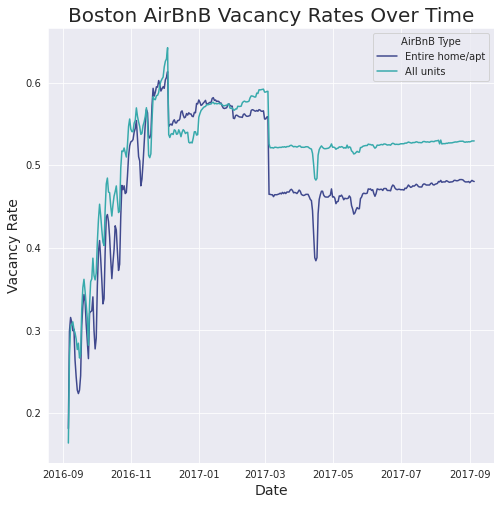

In [40]:
sns.set_style('darkgrid')
sns.set_palette(sns.color_palette('hls', 7))
f, ax = plt.subplots(figsize=(8,8))
sns.lineplot(x='date', y='vacancy', hue='AirBnB Type', palette='mako',
             data=vacancy_by_day[vacancy_by_day['AirBnB Type'].isin(['Entire home/apt', 'All units'])])
plt.title('Boston AirBnB Vacancy Rates Over Time', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Vacancy Rate', fontsize=14);

#### Evaluate the Results

We can see from this chart that the vacancy rate accross all units leveled out to around 50% on any given day in 2017, which the vacancy rate for entire home/apt was slightly lower at roughly 45% on any given day.

This means that of the 2125 units available, roughly 950 units were sitting vacant.

### Growth of Hosts
#### Data Modeling
Let's take a look how many new hosts have been added over time to see what the growth of hosts is like. We can use the Pandas's `.cumsum()` method to calculate a cumulative total, as well as new hosts by date:

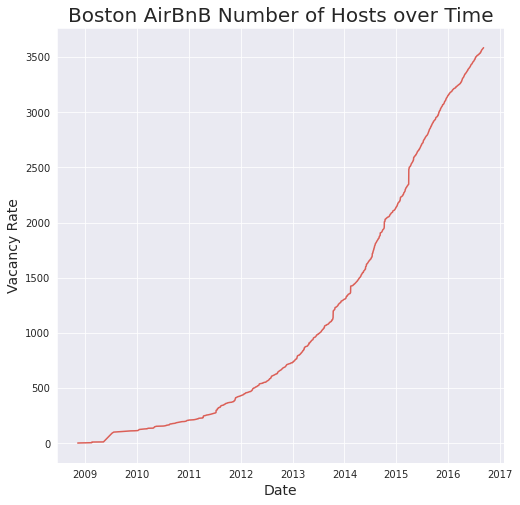

In [41]:
growth = pd.read_csv('https://datagy.io/wp-content/uploads/2020/09/listings.csv', usecols=['host_id', 'host_since'], parse_dates=['host_since'])
growth = pd.pivot_table(growth, index='host_since', values='host_id', aggfunc='count').reset_index()
growth['cumulative total'] = growth['host_id'].cumsum()
f, ax = plt.subplots(figsize=(8,8))
sns.lineplot(data=growth, x='host_since', y='cumulative total', palette='mako')
plt.title('Boston AirBnB Number of Hosts over Time', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Vacancy Rate', fontsize=14);

#### Evaluate the Results
We can see that the number of hosts has grown significantly over the years, and is showing little indication of slowing




### Comparing Prices for Entire Home Unit Types in 3 Neighbourhoods
#### Data Modeling
Let's take a look at affordability. We'll narrow down our analysis into particular niehgbourhoods.

We'll be quite specific in terms of our analysis. We'll take a look at the average monthly rent you'd pay if you were to rent a unit for the entire month. We'll make a few assumptions:
* If a unit offers a monthly discount, that price is used,
* If a unit only offers a weekly discount, we multily that by 4.3 (to account for an average of 30.4 days in a month),
* If a unit doesn't offer a discount, the daily price is multipled by 30

We'll only look at condo/apartment rentals and only at units where the whole unit is available for rent. Because I was only able to find data for 1-bedroom apartments, we'll only look at those. The data was available from [here](http://realestate.boston.com/renting/2020/01/23/median-rent-every-boston-neighborhood/) and covers Fall 2018. 

As our data goes *up to* Fall 2017, let's adjust these rents a little. According to [this website](https://www.rentcafe.com/average-rent-market-trends/us/ma/boston/), rents tend to increase by 3% year over year. Let's decrease them accordingly to make our comparison a little fairer.

In [42]:
rents = [{'Neighborhood': 'Allston', 'Rent': 2150},
 {'Neighborhood': 'Brighton', 'Rent': 1800},
 {'Neighborhood': 'Charlestown', 'Rent': 2500},
 {'Neighborhood': 'Chinatown', 'Rent': 2910},
 {'Neighborhood': 'Mission Hill', 'Rent': 1900},
 {'Neighborhood': 'North End', 'Rent': 2300},
 {'Neighborhood': 'Roslindale', 'Rent': 1600},
 {'Neighborhood': 'West End', 'Rent': 2800}]
rent = pd.DataFrame(rents)
rent['2017 AMR'] = rent['Rent'] * 0.97
rent.drop(['Rent'], axis=1, inplace=True)
rent

,Neighborhood,2017 AMR
0,Allston,2085.5
1,Brighton,1746.0
2,Charlestown,2425.0
3,Chinatown,2822.7
4,Mission Hill,1843.0
5,North End,2231.0
6,Roslindale,1552.0
7,West End,2716.0


Now let's calculate the average rents for the units in the dataset:

In [43]:
bnb = pd.read_csv('https://datagy.io/wp-content/uploads/2020/09/listings.csv', usecols=['id', 'bedrooms', 'property_type', 'room_type', 'price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'neighbourhood_cleansed'])

In [44]:
for col in list(bnb.columns)[5:]:
    bnb[col] = bnb[col].str.replace("$","").str.replace(",","")
    bnb[col] = bnb[col].astype('float')


In [45]:
bnb = bnb[bnb['neighbourhood_cleansed'].isin(list(rent['Neighborhood'].unique()))]
bnb = bnb[bnb['property_type'].isin(['Apartment', 'Condominium'])]
bnb = bnb[bnb['room_type'] == 'Entire home/apt']
bnb = bnb[bnb['bedrooms'] == 1]

In [46]:
bnb['new price'] = bnb['weekly_price'].where(bnb['weekly_price'].notnull(), bnb['price'] * 7)
bnb['new price'] = bnb['monthly_price'].where(bnb['monthly_price'].notnull(), bnb['new price'] * 4.3)
bnb

,id,neighbourhood_cleansed,property_type,room_type,bedrooms,price,weekly_price,monthly_price,security_deposit,cleaning_fee,new price
6,5706985,Roslindale,Apartment,Entire home/apt,1.0,100.0,NaN,NaN,NaN,NaN,3010.0
32,14690527,Roslindale,Apartment,Entire home/apt,1.0,150.0,NaN,NaN,NaN,NaN,4515.0
51,3229255,Roslindale,Apartment,Entire home/apt,1.0,95.0,NaN,NaN,250.0,35.0,2859.5
400,9903,Mission Hill,Apartment,Entire home/apt,1.0,249.0,NaN,5450.0,NaN,150.0,5450.0
402,12379725,Mission Hill,Apartment,Entire home/apt,1.0,239.0,NaN,NaN,NaN,50.0,7193.9
...,...,...,...,...,...,...,...,...,...,...,...
3534,8921130,Allston,Apartment,Entire home/apt,1.0,129.0,712.0,2309.0,NaN,NaN,2309.0
3551,14566657,West End,Apartment,Entire home/apt,1.0,180.0,NaN,NaN,NaN,NaN,5418.0
3565,14335003,Allston,Apartment,Entire home/apt,1.0,146.0,NaN,NaN,NaN,NaN,4394.6
3569,14426586,Charlestown,Apartment,Entire home/apt,1.0,200.0,NaN,NaN,NaN,NaN,6020.0


In [47]:
bnb['security_deposit'].fillna(0, inplace=True)
bnb['cleaning_fee'].fillna(0, inplace=True)
bnb['monthly'] = bnb['new price'] + bnb['security_deposit'] + bnb['cleaning_fee']
bnb = bnb.drop(['price', 'weekly_price', 'monthly_price', 'security_deposit', 
                'cleaning_fee', 'new price', 'bedrooms', 'room_type', 'property_type'], axis=1)
bnb

,id,neighbourhood_cleansed,monthly
6,5706985,Roslindale,3010.0
32,14690527,Roslindale,4515.0
51,3229255,Roslindale,3144.5
400,9903,Mission Hill,5600.0
402,12379725,Mission Hill,7243.9
...,...,...,...
3534,8921130,Allston,2309.0
3551,14566657,West End,5418.0
3565,14335003,Allston,4394.6
3569,14426586,Charlestown,6020.0


In [48]:
rents_airbnb = pd.pivot_table(bnb, index='neighbourhood_cleansed', values='monthly', aggfunc='mean').reset_index()
rents_airbnb

,neighbourhood_cleansed,monthly
0,Allston,3877.947368
1,Brighton,3584.111765
2,Charlestown,5474.587500
3,Chinatown,6368.461538
4,Mission Hill,4995.504000
5,North End,5476.273684
6,Roslindale,3556.500000
7,West End,5909.966667


In [49]:
rents_airbnb.columns = ['Neighborhood', 'Airbnb Rent']
rents_airbnb

,Neighborhood,Airbnb Rent
0,Allston,3877.947368
1,Brighton,3584.111765
2,Charlestown,5474.587500
3,Chinatown,6368.461538
4,Mission Hill,4995.504000
5,North End,5476.273684
6,Roslindale,3556.500000
7,West End,5909.966667


In [50]:
rent = pd.merge(left=rent, right=rents_airbnb, on='Neighborhood', how='left')
rent

,Neighborhood,2017 AMR,Airbnb Rent
0,Allston,2085.5,3877.947368
1,Brighton,1746.0,3584.111765
2,Charlestown,2425.0,5474.587500
3,Chinatown,2822.7,6368.461538
4,Mission Hill,1843.0,4995.504000
5,North End,2231.0,5476.273684
6,Roslindale,1552.0,3556.500000
7,West End,2716.0,5909.966667


In [51]:
rent = pd.melt(rent, id_vars='Neighborhood', var_name='Rent Type', value_name='Rent')


In [52]:
rent

,Neighborhood,Rent Type,Rent
0,Allston,2017 AMR,2085.500000
1,Brighton,2017 AMR,1746.000000
2,Charlestown,2017 AMR,2425.000000
3,Chinatown,2017 AMR,2822.700000
4,Mission Hill,2017 AMR,1843.000000
5,North End,2017 AMR,2231.000000
6,Roslindale,2017 AMR,1552.000000
7,West End,2017 AMR,2716.000000
8,Allston,Airbnb Rent,3877.947368
9,Brighton,Airbnb Rent,3584.111765


#### Evaluate the Results


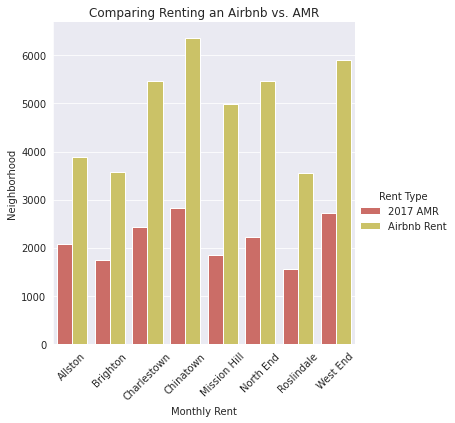

In [53]:
plot = sns.catplot(
    data=rent, kind="bar",
    x="Neighborhood", y="Rent", hue="Rent Type").set(title = "Comparing Renting an Airbnb vs. AMR")
plot.set_axis_labels('Monthly Rent', 'Neighborhood')
plot.set_xticklabels(rotation=45)


### Plotting geographic data
#### Data Modeling

In [54]:
# Load geojson into a geopandas object
neighborhoods = gps.read_file('https://github.com/datagy/mediumdata/raw/master/Boston_Neighborhoods.geojson')

In [55]:
neighborhoods

,OBJECTID,Name,Acres,Neighborhood_ID,SqMiles,ShapeSTArea,ShapeSTLength,geometry
0,27,Roslindale,1605.568237,15,2.51,6.993827e+07,53563.912597,"MULTIPOLYGON (((-71.12593 42.27201, -71.12611 ..."
1,28,Jamaica Plain,2519.245394,11,3.94,1.097379e+08,56349.937161,"POLYGON ((-71.10499 42.32610, -71.10503 42.326..."
2,29,Mission Hill,350.853564,13,0.55,1.528312e+07,17918.724113,"POLYGON ((-71.09043 42.33577, -71.09050 42.335..."
3,30,Longwood,188.611947,28,0.29,8.215904e+06,11908.757148,"POLYGON ((-71.09811 42.33673, -71.09832 42.337..."
4,31,Bay Village,26.539839,33,0.04,1.156071e+06,4650.635493,"POLYGON ((-71.06663 42.34878, -71.06663 42.348..."
5,32,Leather District,15.639908,27,0.02,6.812717e+05,3237.140537,"POLYGON ((-71.05838 42.34983, -71.05834 42.349..."
6,33,Chinatown,76.324410,26,0.12,3.324678e+06,9736.590413,"POLYGON ((-71.05791 42.35238, -71.05811 42.352..."
7,34,North End,126.910439,14,0.20,5.527506e+06,16177.826815,"POLYGON ((-71.05200 42.36884, -71.05219 42.368..."
8,35,Roxbury,2108.469072,16,3.29,9.184455e+07,49488.800485,"POLYGON ((-71.09646 42.29323, -71.09633 42.293..."
9,36,South End,471.535356,32,0.74,2.054000e+07,17912.333569,"POLYGON ((-71.06834 42.34775, -71.06913 42.347..."


In [56]:
# load a new listings dataset with reduced columns
listings = pd.read_csv('https://raw.githubusercontent.com/datagy/mediumdata/master/listings.csv', 
                       usecols=['id', 'neighbourhood_cleansed', 'price', 'review_scores_rating'])

In [57]:
# clean columns for analysis
listings['price_clean'] = listings['price'].str.replace("$","").str.replace(",","")
listings['price_clean'] = pd.to_numeric(listings['price_clean'])
listings['neighbourhood_cleansed'] = listings['neighbourhood_cleansed'].str.replace(" Medical Area", "")


In [58]:
#rename columns to support matching
listings.rename(columns={'neighbourhood_cleansed':'Name'}, inplace=True)

In [59]:
# create two summary tables
price = pd.pivot_table(listings, index='Name', values='price_clean', aggfunc='mean').reset_index()
listings_num = pd.pivot_table(listings, index='Name', values='id', aggfunc='count').reset_index()

In [60]:
# merge summary tables
neighborhoods = pd.merge(left=neighborhoods, right=price, on='Name', how='left')
neighborhoods = pd.merge(left=neighborhoods, right=listings_num, on='Name', how='left')

In [61]:
neighborhoods

,OBJECTID,Name,Acres,Neighborhood_ID,SqMiles,ShapeSTArea,ShapeSTLength,geometry,price_clean,id
0,27,Roslindale,1605.568237,15,2.51,6.993827e+07,53563.912597,"MULTIPOLYGON (((-71.12593 42.27201, -71.12611 ...",98.428571,56.0
1,28,Jamaica Plain,2519.245394,11,3.94,1.097379e+08,56349.937161,"POLYGON ((-71.10499 42.32610, -71.10503 42.326...",138.478134,343.0
2,29,Mission Hill,350.853564,13,0.55,1.528312e+07,17918.724113,"POLYGON ((-71.09043 42.33577, -71.09050 42.335...",121.967742,124.0
3,30,Longwood,188.611947,28,0.29,8.215904e+06,11908.757148,"POLYGON ((-71.09811 42.33673, -71.09832 42.337...",138.444444,9.0
4,31,Bay Village,26.539839,33,0.04,1.156071e+06,4650.635493,"POLYGON ((-71.06663 42.34878, -71.06663 42.348...",266.833333,24.0
5,32,Leather District,15.639908,27,0.02,6.812717e+05,3237.140537,"POLYGON ((-71.05838 42.34983, -71.05834 42.349...",253.600000,5.0
6,33,Chinatown,76.324410,26,0.12,3.324678e+06,9736.590413,"POLYGON ((-71.05791 42.35238, -71.05811 42.352...",232.352113,71.0
7,34,North End,126.910439,14,0.20,5.527506e+06,16177.826815,"POLYGON ((-71.05200 42.36884, -71.05219 42.368...",195.678322,143.0
8,35,Roxbury,2108.469072,16,3.29,9.184455e+07,49488.800485,"POLYGON ((-71.09646 42.29323, -71.09633 42.293...",146.333333,144.0
9,36,South End,471.535356,32,0.74,2.054000e+07,17912.333569,"POLYGON ((-71.06834 42.34775, -71.06913 42.347...",204.349693,326.0


Text(0.5, 1.0, 'Average cost per unit by Neighborhood')

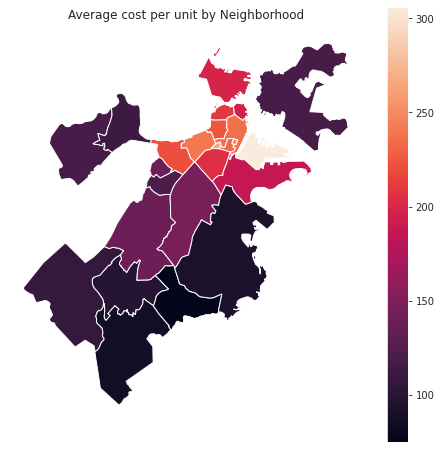

In [62]:
# generate maps
neighborhoods.plot(column='price_clean', legend=True, figsize=(8,8))
plt.axis('off')
plt.title('Average cost per unit by Neighborhood')

Text(0.5, 1.0, '# of Units per Neighborhood')

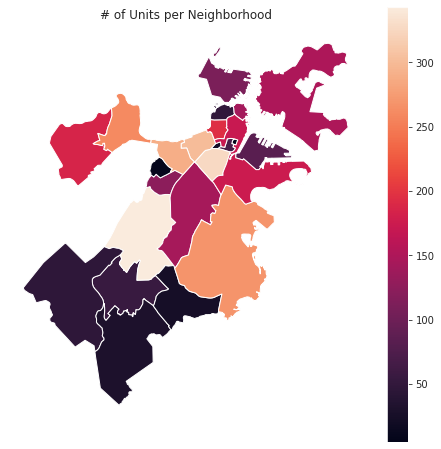

In [63]:
neighborhoods.plot(column='id', legend=True, figsize=(8,8))
plt.axis('off')
plt.title('# of Units per Neighborhood')

#### Evaluate the Results
Applying a geographic lens is a useful tool to notice trends in your data.